<a href="https://colab.research.google.com/github/maggiemcc02/Summer2023_Codes/blob/main/Madden_MP_n_Iter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook I will apply the $(MP)^n$ Iteration to the problem in section 3.3.1 of Niall Madden's *Generating layer-adapted meshes using partial differential equations*

### By : Maggie McCarthy, July 2023

# Install FireDrake

In [1]:
try:
  from firedrake import *
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  from firedrake import *

In [2]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt

# Create the $(MP)^n$ Iteration

In [3]:


def MP_solver_Madden(num_points, iter, epsilon):

  # set the initial mesh

  mesh = UnitSquareMesh(num_points, num_points)

  error_list = []



  for i in range(iter):


    ######################################
    # SOLVE THE PHYSICAL PROBLEM
    #######################################


    print()
    print()
    print('_'* 75)
    print('PHYSICAL SOLVE', i+1)
    print('_'* 75)
    print()
    print()


    # set the function space - a vector function space

    V = FunctionSpace(mesh, "CG", 1)

    # Access the Mesh Coordinates

    xi, eta = SpatialCoordinate(mesh) # mesh is \xi and \eta

    # set the test and and trial functions


    u  = TrialFunction(V)
    v = TestFunction(V)

    # set f

    f = Function(V)


    f.interpolate( xi )

    # define the problem

    a = (  (epsilon**2) * inner( grad(u), grad(v) ) + inner(u, v) ) * dx
    L = ( inner( f, v ) ) * dx



    # define the BC's

    bc1 =  DirichletBC(V, Constant(0) , 1)
    bc3 = DirichletBC(V, Constant(0) , 3)
    bc4 = DirichletBC(V, Constant(0) , 4)


    bcs = [ bc1, bc3, bc4]

    # solve the problem

    u_sol = Function(V)

    solve(a == L, u_sol, bcs = bcs)

    # Colour Plot

    fig, axes = plt.subplots()
    colors = tricontour(u_sol, axes = axes)
    plt.title('Solution Approximation ')
    fig.colorbar(colors)
    plt.show()
    print()
    print()


    #################################################
    # Mesh Density Function
    #################################################


    # Compute the mesh density function

    grad_u = grad(u_sol)
    u_x = grad_u[0]
    u_y = grad_u[1]
    M = sqrt(1 + u_x**2 + u_y**2)



    #############################################
    # Solve the Mesh Problem
    #############################################


    print()
    print()
    print('~' * 35)
    print('MESH SOLVE ', i+1)
    print('~'*35)
    print()
    print()



    # # solve the mesh problem  - x


    # set the test and and trial functions

    x  = TrialFunction(V)
    v = TestFunction(V)

    # define the nonlinear problem

    a =  ( M *inner( grad(x), grad(v) ) )* dx

    L = ( Constant(0) * v  ) * dx

    # define the BC's

    bc1 =  DirichletBC(V, Constant(0), 1)
    bc2 = DirichletBC(V, Constant(1), 2)
    bc3 = DirichletBC(V, xi, 3)
    bc4 = DirichletBC(V, xi, 4)

    bcs = [ bc1, bc2, bc3, bc4]

    # solve

    x_sol = Function(V)

    solve(a == L, x_sol, bcs = bcs)


    # solve the mesh problem - y

    # set the test and and trial functions

    y  = TrialFunction(V)
    v = TestFunction(V)

    # define the nonlinear problem

    a = (M *inner( grad(y), grad(v) ) )* dx

    L = ( Constant(0) * v  ) * dx

    # define the BC's

    bc1 =  DirichletBC(V, eta, 1)
    bc2 = DirichletBC(V, eta, 2)
    bc3 = DirichletBC(V, Constant(0), 3)
    bc4 = DirichletBC(V, Constant(1), 4)

    bcs = [ bc1, bc2, bc3, bc4]

    # solve

    y_sol = Function(V)

    solve(a == L, y_sol, bcs = bcs)

    # Create and plot the new mesh

    N = np.shape(x_sol.dat.data)[0]
    mesh_values = np.zeros([N,2])
    mesh_values[:,0] = x_sol.dat.data
    mesh_values[:,1] = y_sol.dat.data
    mesh.coordinates.dat.data[:] = mesh_values
    fig, axes = plt.subplots()
    triplot(mesh, axes=axes)
    plt.title("Adapted Mesh for Solution ")
    plt.show()

    print()
    print()



    # # Compute the error

    # error_mesh = UnitSquareMesh(50, 50)
    # V_error = FunctionSpace(error_mesh, "CG", 1)


    # # Access the Mesh Coordinates

    # xi_error, eta_error = SpatialCoordinate(error_mesh) # mesh is \xi and \eta

    # # set the test and and trial functions


    # u_error  = TrialFunction(V_error)
    # v_error = TestFunction(V_error)

    # # set f

    # f_error = Function(V_error)
    # f_error.interpolate(xi_error)


    # # define the problem

    # a_error = (  (epsilon**2) * inner( grad(u_error), grad(v_error) ) + inner(u_error, v_error) ) * dx
    # L_error = ( inner( f_error, v_error ) ) * dx



    # # define the BC's

    # bc1 =  DirichletBC(V_error, Constant(0) , 1)
    # bc3 = DirichletBC(V_error, Constant(0) , 3)
    # bc4 = DirichletBC(V_error, Constant(0) , 4)


    # bcs = [ bc1, bc3, bc4 ]

    # # solve the problem

    # u_error = Function(V_error)

    # solve(a_error == L_error, u_error, bcs = bcs)

    # u_interp = project(u_sol, V_error)


    # # compute the error

    # error_coords = error_mesh.coordinates.dat.data

    # my_vom = VertexOnlyMesh(mesh , error_coords)

    # V_vom = FunctionSpace(my_vom, "DG",0)

    # error_vom = Function(V_vom).interpolate(u_sol)

    # u_interp = Function(V_error)

    # u_interp.dat.data[:] = error_vom.dat.data[:]


    # print(sqrt(assemble(dot(u_interp - u_error, u_interp - u_error) * dx)))
    # print()







# Apply to Madden's Problem



___________________________________________________________________________
PHYSICAL SOLVE 1
___________________________________________________________________________




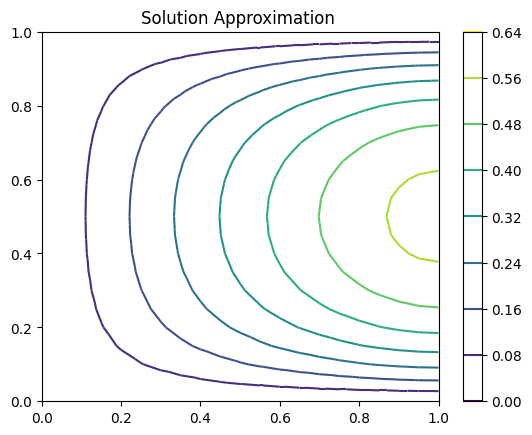





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




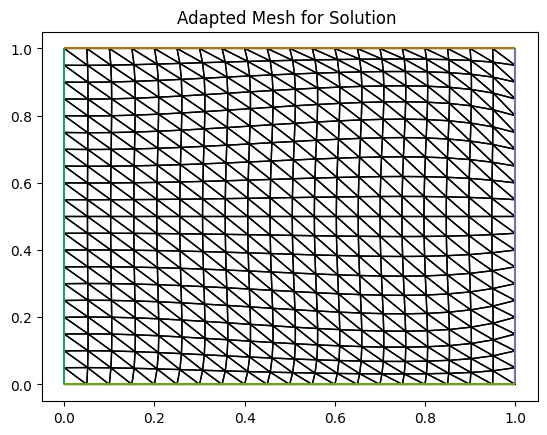





___________________________________________________________________________
PHYSICAL SOLVE 2
___________________________________________________________________________




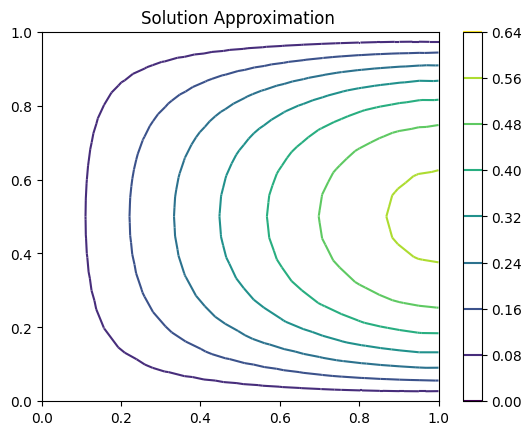





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




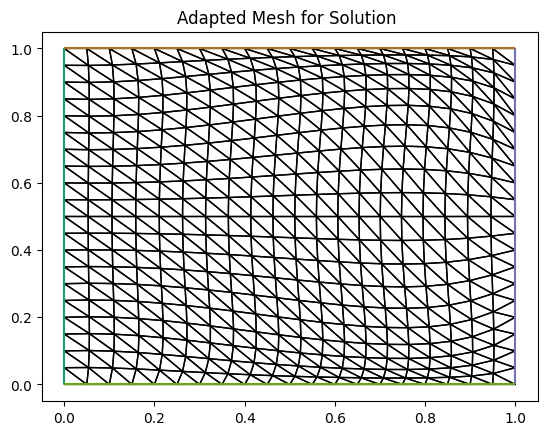





___________________________________________________________________________
PHYSICAL SOLVE 3
___________________________________________________________________________




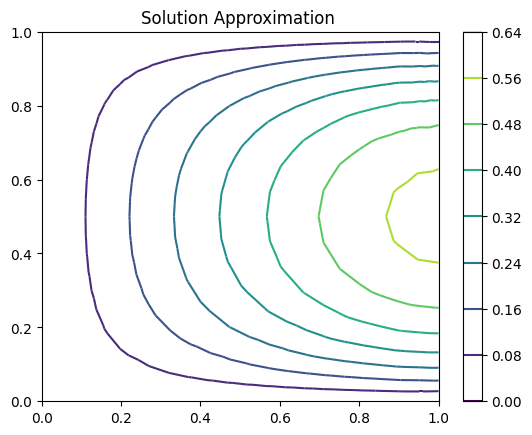





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




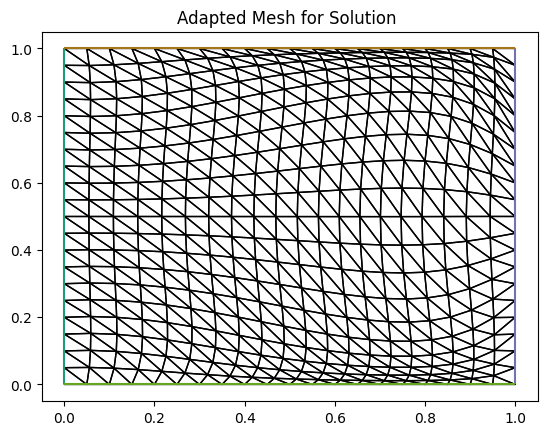





___________________________________________________________________________
PHYSICAL SOLVE 4
___________________________________________________________________________




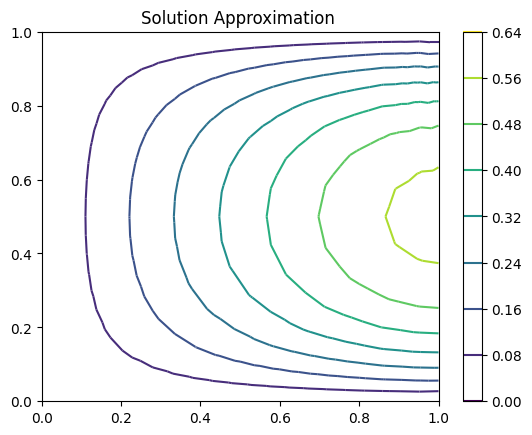





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




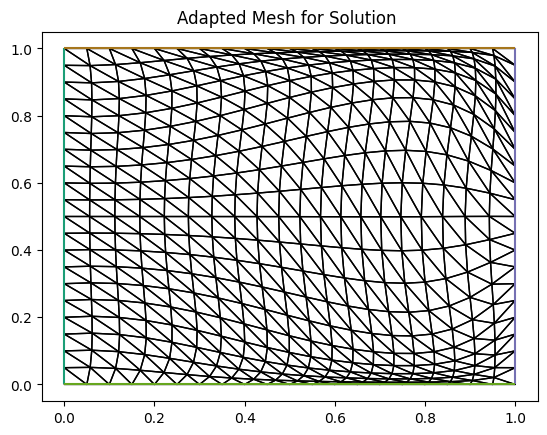





___________________________________________________________________________
PHYSICAL SOLVE 5
___________________________________________________________________________




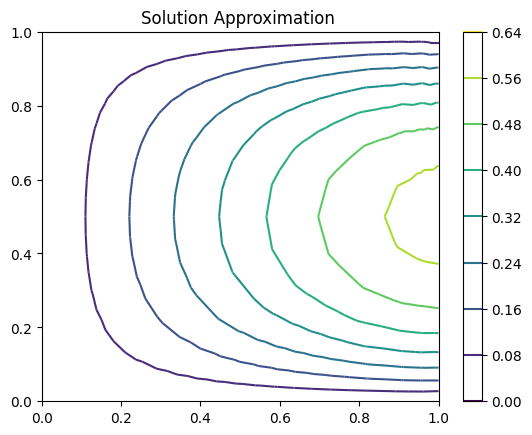





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




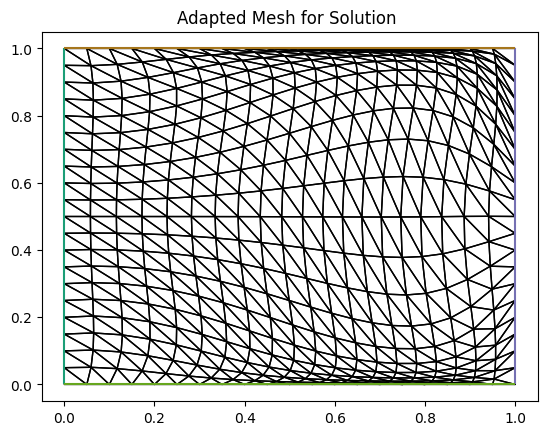





___________________________________________________________________________
PHYSICAL SOLVE 6
___________________________________________________________________________




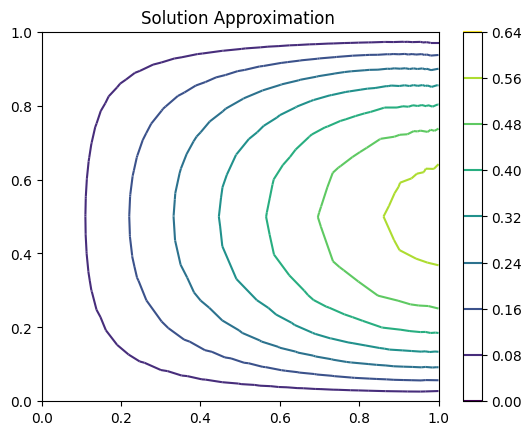





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




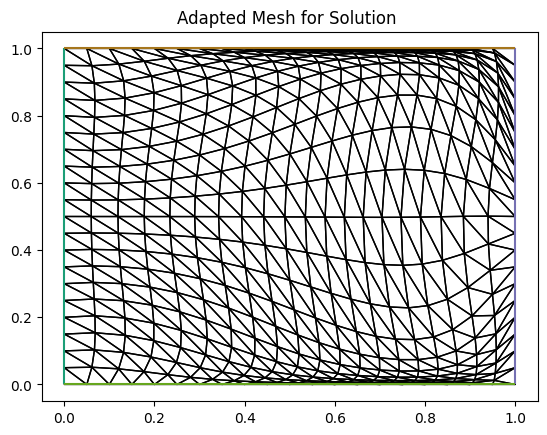





___________________________________________________________________________
PHYSICAL SOLVE 7
___________________________________________________________________________




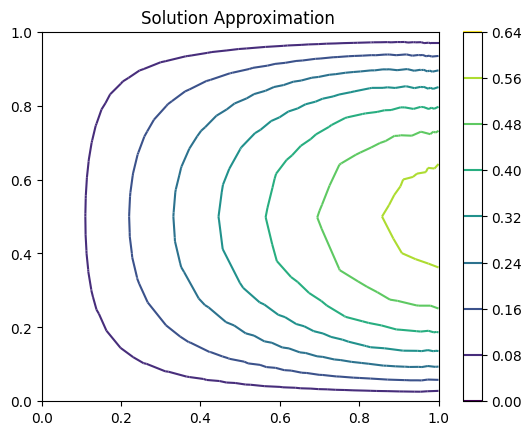





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




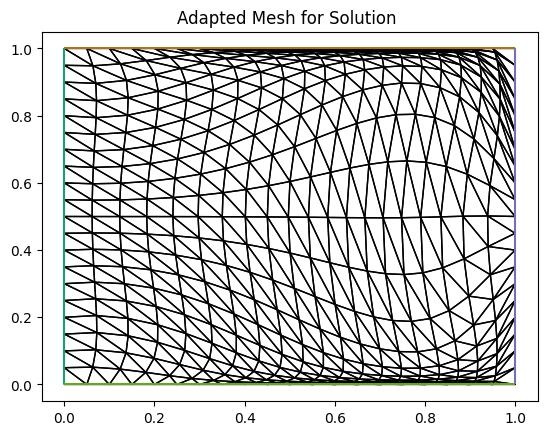





___________________________________________________________________________
PHYSICAL SOLVE 8
___________________________________________________________________________




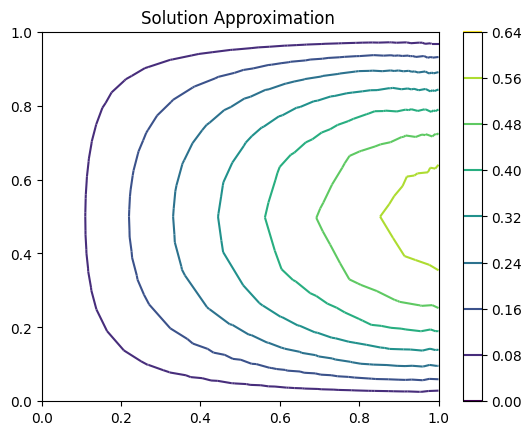





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




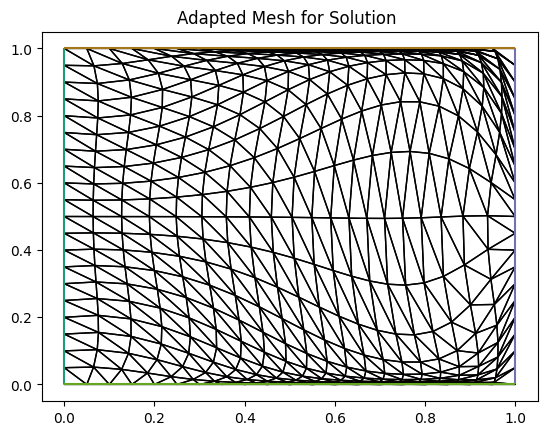





___________________________________________________________________________
PHYSICAL SOLVE 9
___________________________________________________________________________




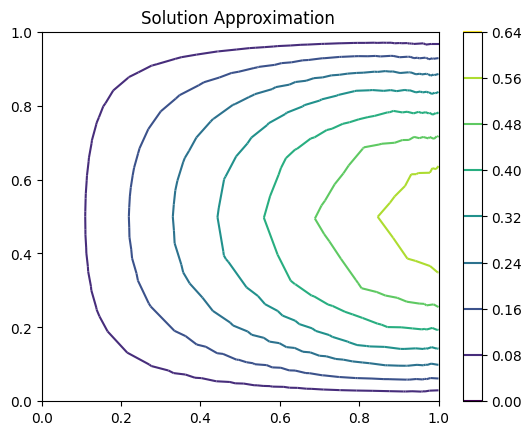





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




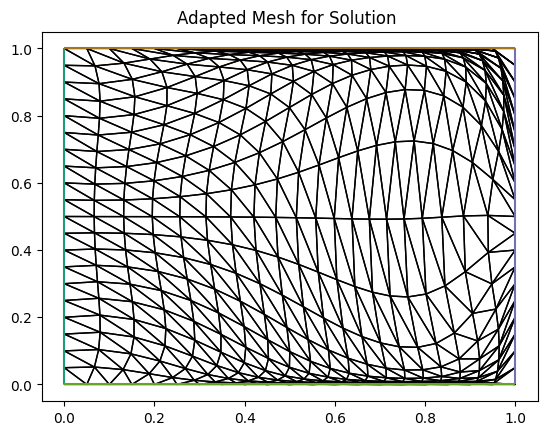





___________________________________________________________________________
PHYSICAL SOLVE 10
___________________________________________________________________________




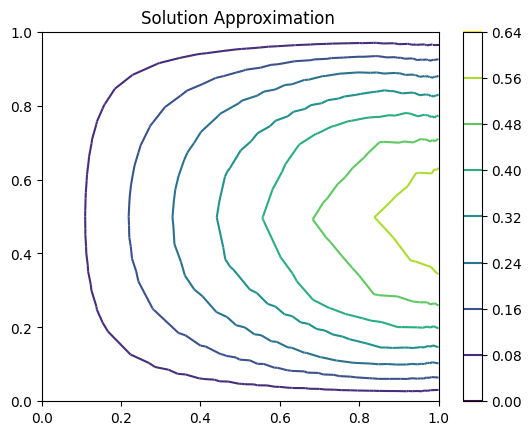





~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MESH SOLVE  10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




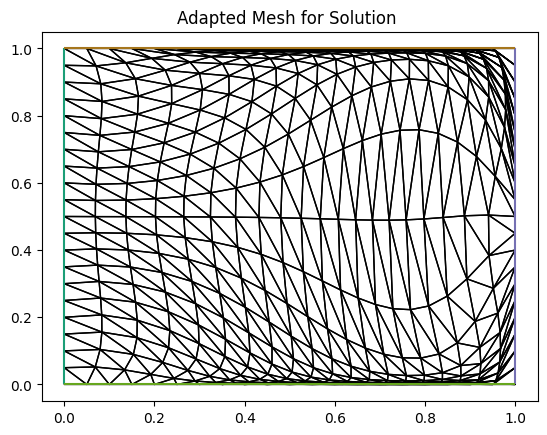

In [4]:
MP_solver_Madden(20, 10, Constant(0.25))